# 项目介绍

本项目致力于开发出适用于小市值股票的因子投资策略，并通过将该策略放在实盘上进行盈利。由于小市值股票资金容量较小，同时波动性较大，因此许多机构并不会投资小市值股票，因此，本项目将延长窗口期，尝试在回撤较大的情况下，从小市值股票中盈利。

## 数据源和数据需求

### jointquant数据源

1. #### 数据需求
   1. 价格数据（后复权）
      1. 收盘价
      2. 开盘价
      3. 最高价
      4. 最低价
      5. 交易量
   2. 估值数据

2. #### 数据tips
   1. daily数据rows不一致：各股票上市时间不一致，在上市以前jq不返回数据，因此数据库中每个股票的数据长度不一致


## 策略优化过程
1. 构建简单动量因子：过去若干天的平均收益率
2. 构建简单财务因子：石川：F-score
3. 对动量因子和财务因子在不同市值组的股票池中进行排序，观察收益情况
4. 优化动量因子和财务因子，从而优化策略

## 功能模块定义
1. 数据下载
2. 数据更新：
   1. 确定是否往股票池中加入新股票等更新细节
   2. 在项目开始以前重新下载一次数据，每次更新END_DATE和UPDATE_START_DATE
   3. 需更新数据：stock_list，trade_date_list, 价格、财务和股本变动数据
3. 因子计算
4. 模型



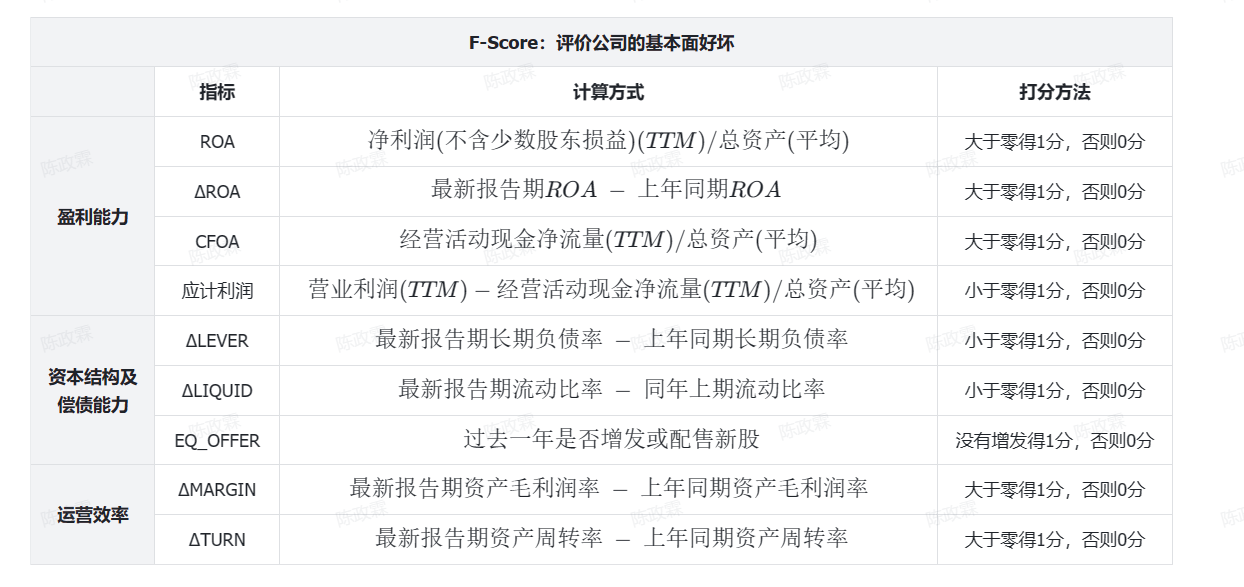

计算方式：

1. roa: indicator.roa
2. delta_roa: roa - roa.shift()
3. CFOA: cash_flow.net_operate_cash_flow / balance.total_assets
4. 应计利润：（income.operating_profit - cash_flow.net_operate_cash_flow） / balance.total_assets
5. delta_lever = lever - lever.shift(1)
   1. lever = balance.total_non_current_liability/balance.total_assets
6. delta_liquid = (流动资产/流动负债) - (流动资产/流动负债).shift()
7. finance.STK_CAPITAL_CHANGE:股本总表，判断时间段内是否发生增发和配售
   1. 时间规则：当2021-01-04发生增发和配售时， 2021-01-05~2022-01-04的得分发生变化
8. delta_margin:gross_profit_margin - gross_profit_margin.shift
9.  delta_turn: (income.operating_revenue/balance.total_assets) - shift

数据需求：

1. roa：indicator.roa
2. 经营活动现金净流量：cash_flow.net_operate_cash_flow
3. 总资产：balance.total_assets
4. 营业利润：income.operating_profit
5. 长期负债：balance.total_non_current_liability
6. 流动资产：balance.total_current_assets
7. 流动负债：balance.total_current_liability
8. 销售毛利率：indicator.gross_profit_margin
9. 营业收入：income.operating_revenue
10. finance.STK_CAPITAL_CHANGE(单独成表)

## 项目时间准则
1. 因子在每日收盘后计算，用于决定股票是否在明日开盘时开仓（平仓）
   1. pct_return: df_open.shift(2) - df_open.shift(1)
   2. 在每日计算因子时，可以用到当日数据，但是不能用到未来数据
   3. 使用因子和pct_return时，不再需要滞后

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import jqdatasdk as jqdata
from tqdm import tqdm
import sqlite3
from abc import abstractmethod
import datetime

In [2]:
'''
Description: 
Author: czl
Date: 2023-07-07 15:58:32
LastEditTime: 2023-08-05 17:38:17
LastEditors:  
'''
from const import *   # import the const.
from classes.basic_calculator import STOCK_LIST, TRADE_DATE_LIST
from classes.basic_functions import DateCalculator, index_columns_check
from classes.data_downloader import DailyPriceDataDownloader, DailyValuationDataDownloader, DailyFinancialDataDownloader, CertainEquityDataDownloader
from classes.data_reader import DailyPriceDataReader, DailyValuationDataReader, DailyFinancialDataReader, CertainEquityDataReader, CrossPriceDataReader, CrossValuationDataReader, FactorsDataReader
from classes.factor_calcualtor import FscoreCalculator
from classes.factor_constructor import FscoreConstructor, FactorsInitializer

from classes.data_constructor import CrossDataInitializer
from classes.signal_generator import SignalGeneratorTemplate, DoubleGenerator
from classes.back_tester import BackTesterTemplate, SimpleBackTester, CompletedBackTester, get_IC

auth success 


*下载数据*

## 下载数据

### 流程
1. 数据下载
2. 格式处理
3. 数据保存：使用sqlite3：方便后续更新数据

### 类定义
1. 数据下载基类：定义 *流程* 中的三个功能
2. 财务数据下载类
3. 价格数据下载类

In [23]:
# daily_price_data_downloader = DailyPriceDataDownloader()
# daily_price_data_downloader.download_data()

# daily_valuation_data_downloader = DailyValuationDataDownloader()
# daily_valuation_data_downloader.download_data()

daily_financial_data_downloader = DailyFinancialDataDownloader()
daily_financial_data_downloader.download_data()

# certain_stock_data_dwownlaoder = CertainEquityDataDownloader()
# certain_stock_data_dwownlaoder.download_data()

100%|██████████| 1035/1035 [49:18<00:00,  2.86s/it]


# 数据检查

In [3]:
# price data
daily_price_data_reader = DailyPriceDataReader()
table_list_price = daily_price_data_reader.get_all_tables_names()
df_price = daily_price_data_reader.get_one_table(stock="000010.XSHE")

print(df_price.shape)
df_price

(3307, 6)


,open,close,high,low,volume,money
date,,,,,,
2010-01-04,39.71,39.24,40.14,39.18,577995.0,22836716.0
2010-01-05,39.24,38.55,39.38,38.28,530340.0,20520166.0
2010-01-06,38.58,38.95,38.98,38.38,456018.0,17627536.0
2010-01-07,38.98,37.42,39.11,36.98,663051.0,25100012.0
2010-01-08,37.05,38.08,38.08,36.65,331602.0,12451286.0
...,...,...,...,...,...,...
2023-08-07,37.49,37.22,38.42,36.29,4260129.0,158050909.0
2023-08-08,37.09,38.55,40.01,36.56,6802537.0,265207665.0
2023-08-09,37.89,36.82,39.21,36.56,4752652.0,177649899.0


In [4]:
# valuation data
daily_valuation_data_reader = DailyValuationDataReader()
table_list_valuation = daily_valuation_data_reader.get_all_tables_names()
df_valuation = daily_valuation_data_reader.get_one_table(stock="000002.XSHE")

print(df_valuation.shape)
df_valuation

(3287, 12)


,code,day,capitalization,circulating_cap,market_cap,circulating_market_cap,turnover_ratio,pe_ratio,pe_ratio_lyr,pb_ratio,ps_ratio,pcf_ratio
date,,,,,,,,,,,,
2010-01-04,000002.XSHE,2010-01-04,1099521.0,965609.50,1165.4923,1023.5461,1.0044,24.7229,28.8977,3.3354,2.4284,15.1911
2010-01-05,000002.XSHE,2010-01-05,1099521.0,965609.50,1139.1038,1000.3714,1.9145,24.1631,28.2434,3.2599,2.3734,14.8472
2010-01-06,000002.XSHE,2010-01-06,1099521.0,965609.50,1139.1038,1000.3714,1.4070,24.1631,28.2434,3.2599,2.3734,14.8472
2010-01-07,000002.XSHE,2010-01-07,1099521.0,965609.50,1130.3076,992.6466,1.1935,23.9766,28.0253,3.2347,2.3551,14.7325
2010-01-08,000002.XSHE,2010-01-08,1099521.0,965609.50,1138.0043,999.4058,1.1240,24.1398,28.2161,3.2568,2.3712,14.8328
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10,000002.XSHE,2023-07-10,1193071.0,971666.75,1659.5616,1351.5884,0.4127,7.3321,7.3374,0.6746,0.3256,-1181.4331
2023-07-11,000002.XSHE,2023-07-11,1193071.0,971666.75,1653.5963,1346.7301,0.6836,7.3057,7.3110,0.6722,0.3245,-1177.1864
2023-07-12,000002.XSHE,2023-07-12,1193071.0,971666.75,1632.1211,1329.2401,0.7533,7.2108,7.2161,0.6634,0.3202,-1161.8983


In [12]:
# financial data
daily_financial_data_reader = DailyFinancialDataReader()
table_list_financial = daily_financial_data_reader.get_all_tables_names()
df_financial = daily_financial_data_reader.get_one_table(stock="000010.XSHE")

print(df_financial.shape)
df_financial

(3307, 11)


,day,code,roa,net_operate_cash_flow,total_assets,operating_profit,total_non_current_liability,total_current_assets,total_current_liability,gross_profit_margin,operating_revenue
date,,,,,,,,,,,
2010-01-04,2010-01-04,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-05,2010-01-05,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-06,2010-01-06,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-07,2010-01-07,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-08,2010-01-08,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,2023-08-07,000010.XSHE,-0.99,5571697.5,3.472760e+09,-3.498326e+07,67695480.0,2.623753e+09,2.543769e+09,7.05,123962808.0
2023-08-08,2023-08-08,000010.XSHE,-0.99,5571697.5,3.472760e+09,-3.498326e+07,67695480.0,2.623753e+09,2.543769e+09,7.05,123962808.0
2023-08-09,2023-08-09,000010.XSHE,-0.99,5571697.5,3.472760e+09,-3.498326e+07,67695480.0,2.623753e+09,2.543769e+09,7.05,123962808.0


In [25]:
# equity data
certain_equity_data_reader = CertainEquityDataReader()
table_list_equity = certain_equity_data_reader.get_all_tables_names()
df_equity = certain_equity_data_reader.get_one_table(stock="000002.XSHE")


df_equity.head()

,id,company_id,company_name,code,change_date,pub_date,change_reason_id,change_reason,share_total,share_non_trade,...,share_h,share_h_limited,share_management,share_management_limited,share_other_trade,control_shareholder_limited,core_employee_limited,individual_fund_limited,other_legal_limited,other_limited
date,,,,,,,,,,,,,,,,,,,,,
2017-03-27,1119,430000002,万科企业股份有限公司,000002.XSHE,2016-12-31,2017-03-27,306019.0,定期报告,1.103915e+06,NaN,...,131495.5468,NaN,NaN,0.0,NaN,None,None,None,None,None
2017-08-25,6513,430000002,万科企业股份有限公司,000002.XSHE,2017-06-30,2017-08-25,306019.0,定期报告,1.103915e+06,NaN,...,131495.5468,NaN,NaN,0.0,NaN,None,None,None,None,None
2018-03-27,10984,430000002,万科企业股份有限公司,000002.XSHE,2017-12-31,2018-03-27,306019.0,定期报告,1.103915e+06,NaN,...,131495.5468,NaN,NaN,0.0,NaN,None,None,None,None,None
2008-03-21,24505,430000002,万科企业股份有限公司,000002.XSHE,2007-12-31,2008-03-21,306019.0,定期报告,6.872006e+05,0.0,...,0.0000,NaN,NaN,NaN,0.0,None,None,None,None,None
2008-06-05,24799,430000002,万科企业股份有限公司,000002.XSHE,2008-06-16,2008-06-05,306011.0,转增,1.099521e+06,0.0,...,0.0000,NaN,NaN,NaN,NaN,None,None,None,None,None


In [7]:
# check the number of stocks in different db
print(len(table_list_price), len(table_list_financial), len(table_list_equity))

5015 5015 5015


## 计算因子
定义因子计算类和计算函数：
1. 因子计算类：接收数据，并计算单个股票的因子
2. 计算函数：链接data_reader和feature_calculator

### 基类：
1. stcok_list, trade_date_list(可能用于不同股票在时间上的对齐)
2. 计算因子的函数

In [7]:
f_calcualtor = FscoreCalculator()
f_calcualtor.calculate_factor(financial_data=df_financial, equity_data=df_equity)

NameError: name 'df_financial' is not defined

## 价格数据处理
1. 读取价格数据：所有股票整合到一个表，计算差分等
2. 收益率计算原则：（今日价格 - 昨天价格）/ 昨天价格：在计算收益率的时候，需要将信号滞后一天

In [4]:
cross_data_initializer = CrossDataInitializer()
cross_data_initializer.all_cross_data_initialize()

In [21]:
cross_price_data_reader = CrossPriceDataReader()
# cross_price_data_reader.get_all_tables_names()
# result_dict = cross_price_data_reader.get_all_tables()

In [23]:
cross_valuation_data_reader = CrossValuationDataReader()
# result_dict = cross_valuation_data_reader.get_all_tables()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2440\2905015672.py:39: DtypeWarning: Columns (67,69,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,521,522,926,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1

## 定义因子融合器：
1. 排序器
2. 回归器等

In [3]:
'''
Description: 
Author: czl
Date: 2023-07-07 15:58:32
LastEditTime: 2023-07-14 16:18:59
LastEditors:  
'''
factors_initializer = FactorsInitializer()
# factors_initializer.reversal_initalizer()
factors_initializer.valuation_initalizer()
# factors_initializer.initialize_all_factors()

In [4]:
factors_reader = FactorsDataReader()
factors_reader.get_valuations()

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10,-0.053215,-0.068750,0.345052,-0.299644,-0.051542,-0.307455,0.042587,0.103899,-0.051015,-0.031764,...,-0.327446,-0.153352,-0.142426,0.135344,0.011235,0.074706,0.106393,0.182576,-0.237521,0.069397
2023-07-11,-0.067086,-0.071009,0.491859,-0.309524,-0.038926,-0.262314,0.043351,0.130716,-0.042765,-0.008279,...,-0.247748,-0.110856,-0.084355,0.148810,0.079984,0.100994,0.145037,0.213228,-0.198916,0.073548
2023-07-12,-0.051308,-0.078693,0.433471,-0.383105,-0.057059,-0.254030,0.017468,0.109138,-0.076554,-0.034604,...,-0.274173,-0.107127,-0.087468,0.142435,0.067002,0.037221,0.080890,0.175199,-0.184111,0.004887


检查fscore控制来源

In [4]:
f_constructor = FscoreConstructor()
f_constructor.calculate_factor_for_one(stock="688789.XSHG")


## 2023-07-11 和 2023-07-12大半部分stock无financial数据，数据初始化的时间差异，在研究时不使用这两天数据即可

date
2021-08-30    3
2021-08-31    3
2021-09-01    3
2021-09-02    3
2021-09-03    3
             ..
2023-07-10    6
2023-07-11    6
2023-07-12    6
2023-07-13    6
2023-07-14    6
Name: 688789.XSHG, Length: 453, dtype: int64

排序器
1. 单独排序
2. 双重排序

回测器：
1. 收益曲线
2. 指标计算

In [3]:
factors_reader = FactorsDataReader()
df_fscore = factors_reader.get_fscores()

In [9]:
# 数据观察
df_fscore.head()

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


F_SCORE除了向分位数标准，还要测试绝对值标准

e:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
e:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([[  0., 800., 668., ...,   0.,   0.,   0.],
        [  0., 156., 225., ..., 230.,  53.,   0.],
        [  0., 237., 295., ..., 177.,   7.,   0.],
        ...,
        [  0.,  82.,   8., ..., 142.,   0.,   0.],
        [  0.,   0.,   0., ..., 217., 186.,   0.],
        [ 10.,  81., 167., ...,  15.,   0.,   0.]]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 5015 BarContainer objects>)

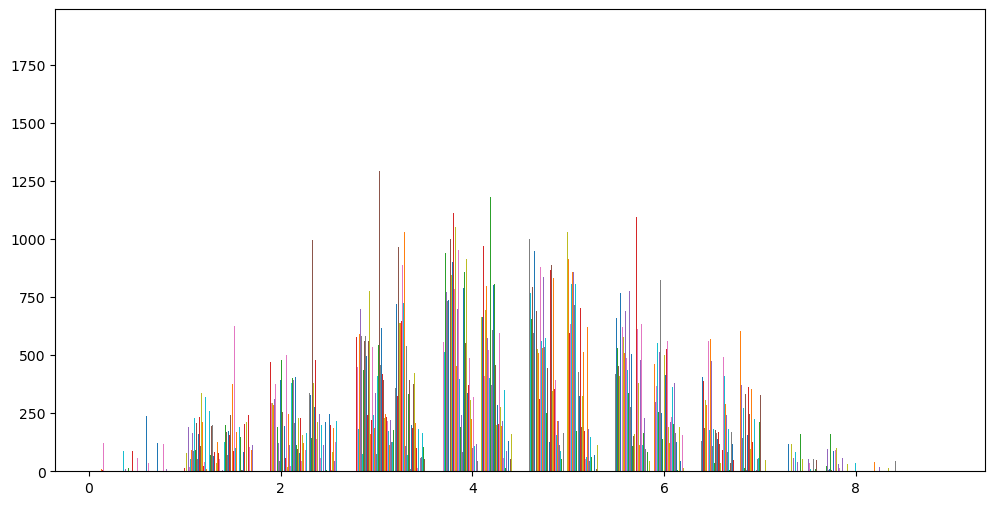

In [10]:
fig = plt.figure(figsize=(12,6))
plt.hist(df_fscore)

由于F-Scroe集中在中间分布，因此在排序时，同一得分的不同股票排为不同的排序，否则不同组之间数量过于不平衡

## 信号产生器
1. 功能：接受单个或者多个因子值，进行相关的处理以后（因子融合后分组和双重排序等），产生交易信号
   
2. 基类功能（单次排序分组的功能）
   1. 排序：nan仍为nan，同一值排为不同的序
   2. 每一日内分为若干组
   3. 对第一组和最后一组进行绝对值过滤
   
3. 输出：
   1. columns为stock_list, index为trade_date_list的dataframe，value为每一支股票所属于的组别。（0为不交易组）
   
4. 子类设计：
   1. 排序信号器：对传入的多个因子进行多次排序分组，产生交易信号
   2. 融合信号器：通过回归等方式对传入的多个因子进行融合以后，对融合后的因子值进行单次排序分组

In [4]:
signal_generator = SignalGeneratorTemplate()

# df_rank = df_fscore.rank(axis=1, na_option="keep", method="first")
# df_signal = signal_generator.group_by_rank(df_rank)

df_signal = signal_generator.get_signal(df_fscore)

In [61]:
df_fscore

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,1.0,3,2,2,3,1,2,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10,4.0,6,3,0,2,5,4,4,3,3,...,2.0,3.0,6.0,4.0,2.0,6.0,5.0,6.0,6.0,5.0
2023-07-11,4.0,6,3,0,2,5,4,4,3,3,...,2.0,3.0,6.0,4.0,2.0,6.0,5.0,6.0,6.0,5.0
2023-07-12,4.0,6,3,0,2,5,4,4,3,3,...,2.0,3.0,6.0,4.0,2.0,6.0,5.0,6.0,6.0,5.0


In [57]:
df_signal.head()

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1,3,2,2,3,1,2,2,3,3,...,0,0,0,0,0,0,0,0,0,0
2010-01-05,1,3,2,2,3,1,2,2,3,3,...,0,0,0,0,0,0,0,0,0,0
2010-01-06,1,3,2,2,3,1,2,2,3,3,...,0,0,0,0,0,0,0,0,0,0
2010-01-07,1,3,2,2,3,1,2,2,3,3,...,0,0,0,0,0,0,0,0,0,0
2010-01-08,1,3,2,2,3,1,2,2,3,3,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# 检查分组情况
print(df_signal.shape)

for i in range(6):
    print(i, (df_signal==i).sum().sum())

(3287, 5015)
0 6535754
1 1988447
2 1989628
3 1989837
4 1989628
5 1991011


双重排序器定义

#### 双重排序测试

In [44]:
# read data
factors_reader = FactorsDataReader()
df_fscore = factors_reader.get_fscores()
df_reversals = factors_reader.get_reversals()

price_reader = CrossPriceDataReader()
df_open = price_reader.read_open()

In [45]:
double_ranker = DoubleGenerator()

100%|██████████| 36/36 [00:53<00:00,  1.50s/it]


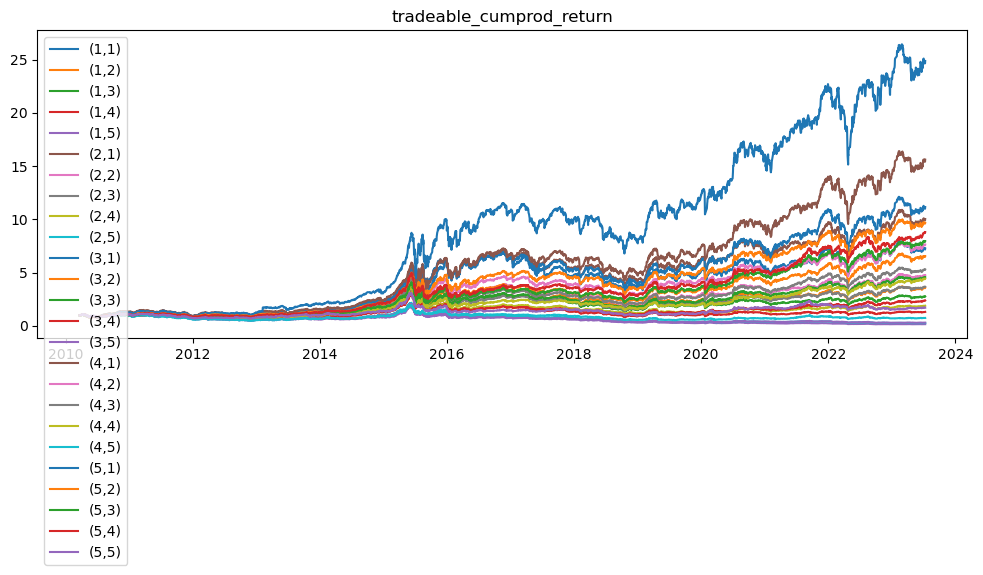

In [70]:
independent_signal = double_ranker.get_signal_independent(df_factor_1=df_fscore, df_factor_2=df_reversals)
independent_simple_bact_tester = SimpleBackTester(open_df=df_open, singnal_df=independent_signal)
independent_simple_bact_tester.get_tradable_return_plot()

100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


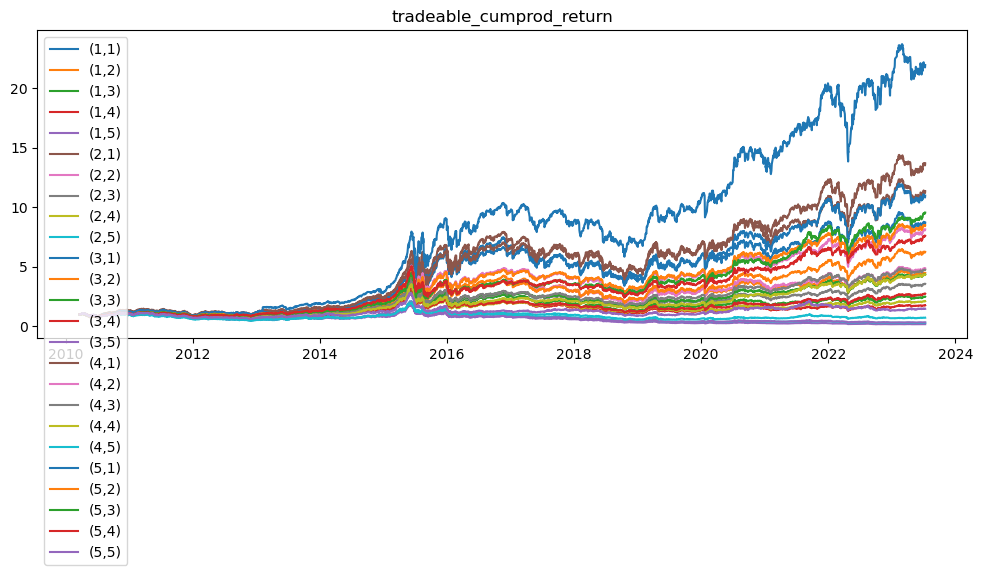

In [69]:
dependent_signal = double_ranker.get_signal_dependent(df_factor_first=df_fscore, df_factor_second=df_reversals)
dependent_simple_bact_tester = SimpleBackTester(open_df=df_open, singnal_df=dependent_signal)
dependent_simple_bact_tester.get_tradable_return_plot()

结论（5，1）和（4，1）组表现最好，即有财务数据支撑，但是动量下降的股票表现较好（反转）

testing

In [32]:
a_test = pd.DataFrame({"a":[1,2,3], "b":[4,5,6]})
b_test = pd.DataFrame({"a":[11,22,33], "b":[44,55,66]})

In [33]:
test_c = "("+a_test.astype("str") + ","+b_test.astype("str")+")"

In [18]:
test_d = test_c.applymap(lambda x: eval(x))

tuple

In [27]:
type(test_d.iloc[1,1])

tuple

## 定义回测器：接受收盘价和融合器的结果

### 回测器基类
1. 设计：
   1. 接受收盘价和交易信号
   2. 计算并保存每组的累计收益率的dataframe（后续画图和计算指标需要反复用到该数据）
   
2. 功能设计：
   1. 计算收盘价变动率
   2. 获得所有的组别
   3. 计算每组收益(abstractmethod, 不同的子类考虑滑点和手续费)
   4. 计算ic,sharp,calmar等指标
   5. 画图


### 子类设计
1. 无滑点和手续费
2. 加入滑点和手续费:
   1. 修改pct_return的计算方式：滑点
   2. 修改get_return_df的定义：手续费（并非日度平仓）


def get_IC(rank1, rank2):
    IC = pd.DataFrame(0, index=rank2.index, columns=['IC'])
    # 做IC相关
    for index, row in rank1.iterrows():
        rank1_row = row.dropna()
        rank2_row = rank2.loc[index].dropna()
        IC.loc[index] = rank1_row.corr(rank2_row, method='spearman')
    return IC

In [26]:
price_reader = CrossPriceDataReader()
# df_open = open_df
df_open = price_reader.read_open()


In [63]:
simple_bact_tester = SimpleBackTester(open_df=df_open, singnal_df=df_signal)

# simple_bact_tester = SimpleBackTester(open_df=df_open.iloc[2000: , :], singnal_df=df_signal.iloc[2000: , :])

100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


In [13]:
simple_bact_tester.get_all_indicators()

,0,1,2,3,4,5
max_drawdown,1.000000,0.723336,0.734841,0.726281,0.735365,0.757316
yearly_return,-2.167616,0.171731,0.135550,0.108625,0.075663,0.028486
sharp,-0.256421,0.036700,0.029859,0.024224,0.017007,0.006444
calmar,-0.008670,0.000950,0.000738,0.000598,0.000412,0.000150


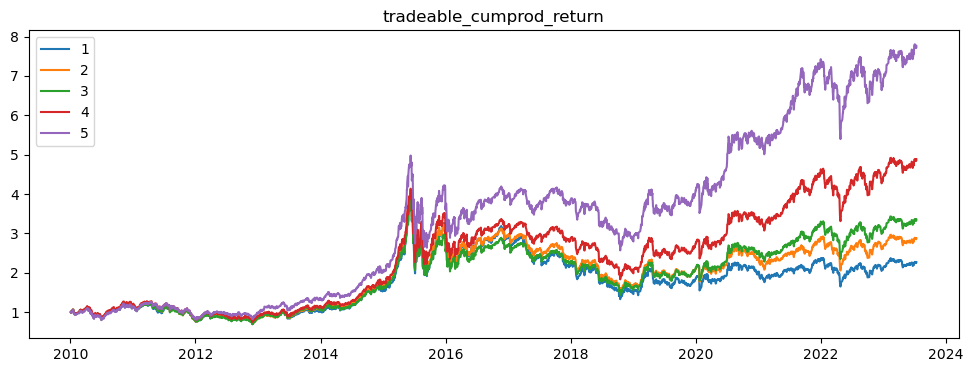

In [64]:
simple_bact_tester.get_tradable_return_plot()

## 带手续费和滑点和back_tester
1. 新增加功能：寻找开仓和平仓时间
2. 修改开仓和平仓的价格
   1. 开仓：+（手续费+滑点）
   2. 平仓：-（手续费+滑点）

In [65]:
completed_back_tester = CompletedBackTester(open_df=df_open, singnal_df=df_signal)

100%|██████████| 6/6 [01:20<00:00, 13.37s/it]


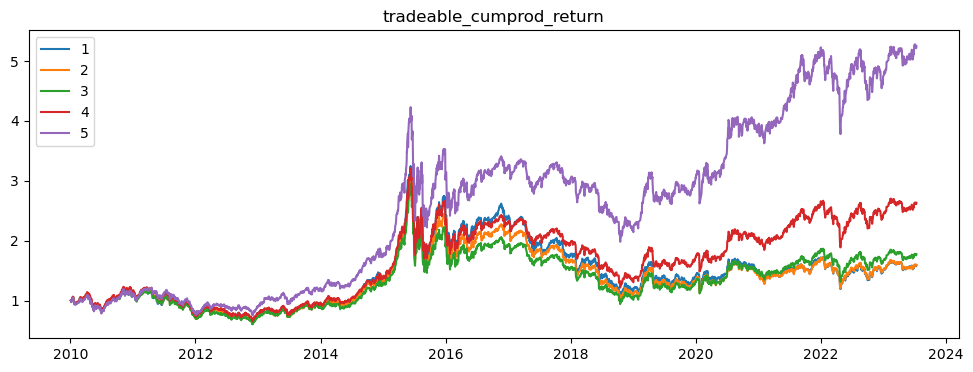

In [66]:
completed_back_tester.get_tradable_return_plot()

In [67]:
completed_back_tester.get_all_indicators()

,0,1,2,3,4,5
max_drawdown,0.775482,0.677491,0.674358,0.680468,0.619745,0.531070
yearly_return,2.850907,0.076935,0.074848,0.081842,0.111439,0.163576
sharp,0.334604,0.017006,0.017032,0.018859,0.025819,0.038065
calmar,0.014705,0.000454,0.000444,0.000481,0.000719,0.001232


In [35]:
open_signal[open_signal is True] = 1.003
open_signal[open_signal is False] = 1

#### 交易信号频率转换：降低换仓频率
1. DateCalculator: 寻找开仓时间点：每月末、每周末等
2. SignalTransferTemplate: 将一段时间内的交易信号统一
   1. 统一方式：最新一天或者过去的均值（待测试）

SignalTransfer功能设计
1. find trading_date_list:找到调仓日期
2. 在持仓周期内统一信号